In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.datatype import MRIDataset
from src.renderer_copy import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

In [7]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load the NIfTI file
img_iUS = nib.load(image_path / iUS_file)
img_t1 = nib.load(image_path / t1_file)
img_t2 = nib.load(image_path / t2_file)

# Extract image data as a numpy array
img_iUS_data = img_iUS.get_fdata()
img_t1_data = img_t1.get_fdata()
img_t2_data = img_t2.get_fdata()
print("Image shape:", img_iUS_data.shape)

slice_idx = img_iUS_data.shape[2] // 2

# plt.imshow(img_iUS_data[:, :, slice_idx], cmap="gray")
# plt.title(f"Slice {slice_idx} of the iUS volume")
# plt.axis("off")
# plt.show()

# plt.imshow(img_t1_data[:, :, slice_idx], cmap="gray")
# plt.title(f"Slice {slice_idx} of the MRI T1 volume")
# plt.axis("off")
# plt.show()

# plt.imshow(img_t2_data[:, :, slice_idx], cmap="gray")
# plt.title(f"Slice {slice_idx} of the MRI T2 volume")
# plt.axis("off")
# plt.show()

Image shape: (256, 256, 256)


In [58]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [59]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "T1", axis=0)

In [65]:
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

In [14]:
T1_norm = (T1_volume - T1_volume.min()) / (T1_volume.max() - T1_volume.min())
T2_norm = (T2_volume - T2_volume.min()) / (T2_volume.max() - T2_volume.min())

In [33]:
# Stack T1 and T2 features
features = np.stack((T1_norm.flatten(), T2_norm.flatten()), axis=1)

# Cluster into 4 classes
kmeans = KMeans(n_clusters=4, random_state=0).fit(features)
labels = kmeans.labels_.reshape(T1_norm.shape) # Now labels[i,j,k] is the class for voxel (i,j,k)

impedance_values = {
    "Air": 400,
    "Fat": 1.38e6,
    "Soft tissue": 1.6e6,
    "Bone": 7.8e6
}

category_mapping = {
    0: "Air",
    1: "Bone",
    2: "Soft tissue",
    3: "Fat"
}


impedance_mapping = {label: impedance_values[category_mapping[label]] for label in range(4)}

# Vectorized assignment
vectorized_mapping = np.vectorize(impedance_mapping.get)
impedance_volume = vectorized_mapping(labels)



In [34]:
kmeans.cluster_centers_

array([[0.01654006, 0.01166139],
       [0.0881808 , 0.48699504],
       [0.1643944 , 0.19192773],
       [0.39547628, 0.15004751]], dtype=float32)

In [35]:
unique_values, counts = np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value {value} - {category_mapping[value]}: {count:,} occurrences")

Value 0 - Air: 6,251,924 occurrences
Value 1 - Bone: 1,010,141 occurrences
Value 2 - Soft tissue: 8,019,157 occurrences
Value 3 - Fat: 1,495,994 occurrences


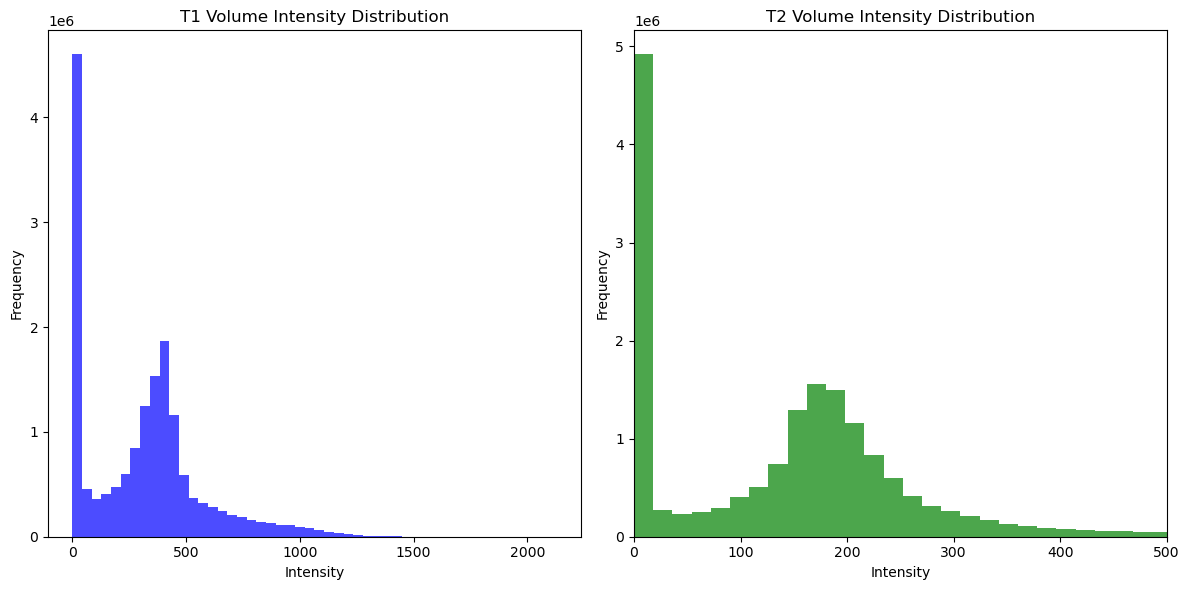

In [79]:
# Plot histograms for T1_volume and T2_volume
plt.figure(figsize=(12, 6))

# T1_volume histogram
plt.subplot(1, 2, 1)
plt.hist(T1_volume.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('T1 Volume Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
# plt.xlim(0,500)

# T2_volume histogram
plt.subplot(1, 2, 2)
plt.hist(T2_volume.flatten(), bins=50, color='green', alpha=0.7)
plt.title('T2 Volume Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.xlim(0,500)

plt.tight_layout()
plt.show()

In [48]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion

def brain_mask(volume, threshold=50):
    """
    Quick brain mask generation by thresholding and cleaning.
    volume: np.ndarray, MRI volume
    threshold: int, intensity below which is considered air/background
    """
    mask = volume > threshold
    mask = binary_dilation(mask, iterations=2)
    mask = binary_erosion(mask, iterations=2)
    return mask

def zscore_normalize(volume, mask):
    """
    Normalize a volume by z-scoring inside a brain mask.
    Args:
        volume: torch.Tensor, the 3D volume to normalize.
        mask: torch.Tensor, binary brain mask of the same shape as the volume.
    
    Returns:
        torch.Tensor: The z-score normalized volume.
    """
    volume = volume.float()
    brain_voxels = volume[mask > 0]
    mean = brain_voxels.mean()
    std = brain_voxels.std()
    
    volume_norm = (volume - mean) / (std + 1e-8)  
    return volume_norm



In [66]:
# prepare data
t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = train_mlp(X1, Y1, input_dim=1)
model_t2 = train_mlp(X2, Y2, input_dim=1)

Z_vol = compute_impedance_volume(T1_volume, model=model_t1, thresh=50)

UR = UltrasoundRenderer(200, 0.1)

angle = 20  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor([70,20.,0]),
    directions=torch.tensor(directions),
    angle=45
)

c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\2025 02 Advances in Computer Vision\Final Project\DiffUS_DifferentiableUltrasoundfromMRI\src\renderer_copy.py:451: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



RuntimeError: Index put requires the source and destination dtypes match, got Int for the destination and Float for the source.

In [71]:
import numpy as np
import torch
from torch import tensor

# --------------------------
# Synthetic Data Generation
# --------------------------

# Create a synthetic 3D volume (80x100x120) with random tissue values
T1_volume = T1_volume.float()

# Create synthetic T1/T2 training pairs
t1 = np.array([-2.0, -1.0, 0.0, 1.5]).reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0, 2.0]).reshape(-1,1)
z1 = np.array([400, 1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z2 = np.array([400, 1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

# Convert to tensors
X1 = tensor(t1, dtype=torch.float32)
Y1 = tensor(z1, dtype=torch.float32)
X2 = tensor(t2, dtype=torch.float32)
Y2 = tensor(z2, dtype=torch.float32)

# --------------------------
# Model Training
# --------------------------

# Train MLP models for impedance estimation
model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

# Compute impedance volume using first model
Z_vol = ImpedanceEstimator.compute_impedance_volume(
    volume=T1_volume,
    model=model_t1,
    threshold=50  # Threshold for brain mask
)

In [77]:
# --------------------------
# Ultrasound Simulation Setup
# --------------------------

# Configure renderer
renderer = UltrasoundRenderer(
    num_samples=255,    # Samples per ray
    attenuation_coeff=0.1  # Exponential decay factor
)

# Define ultrasound source in 3D space (x, y, z)
source_3d = tensor([70.0, 20.0, 0.0])  # Position in volume coordinates

# Configure beam parameters
n_rays = 200            # Number of beams in fan
max_angle = 20          # Maximum beam angle (degrees)

# Generate beam directions (3D vectors in XZ plane)
thetas = np.radians(np.linspace(-max_angle, max_angle, n_rays))
directions = tensor([
    [np.sin(theta), 0, np.cos(theta)]  # Unit vectors in XZ plane
    for theta in thetas
], dtype=torch.float32)

# --------------------------
# Simulation & Visualization
# --------------------------

# Simulate ultrasound echoes
echoes = renderer.render_frame(
    impedance_volume=Z_vol,
    source=source_3d,
    directions=directions
)

Echoes shape: torch.Size([200, 255])


In [78]:
# Prepare visualization parameters
source_2d = np.array([source_3d[0].item(), source_3d[2].item()])  # XZ projection
spacing = 0.1  # mm per voxel (example value)

# Visualize in fan-beam geometry
renderer.visualize(
    echoes=echoes,
    visualization_type='beam',
    source=source_2d,
    angles=thetas,
    spacing=spacing
)

# Generate and visualize B-mode image
bmode = UltrasoundVisualizer.plot_bmode(echoes.numpy())
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

In [61]:
T1_mask = brain_mask(T1_volume, threshold=50)
T2_mask = brain_mask(T2_volume, threshold=50)

T1_norm = zscore_normalize(T1_volume, T1_mask)
T2_norm = zscore_normalize(T2_volume, T2_mask)

In [52]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the MLP
class ImpedanceMLP(nn.Module):
    def __init__(self, input_dim=1):
        super(ImpedanceMLP, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Function to train an MLP
def train_mlp(X, y, input_dim=1, n_epochs=5000, lr=1e-3):
    model = ImpedanceMLP(input_dim=input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

    return model


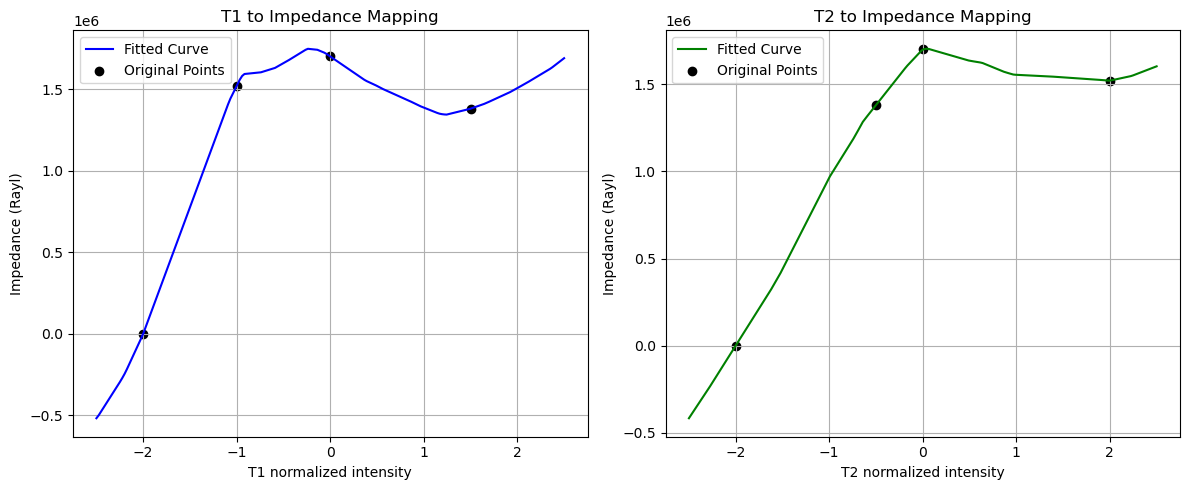

In [55]:
# Ground-truth values for T1
t1_values = np.array([-2.0, -1.0, 0.0, 1.5]).reshape(-1, 1)
impedances_t1 = np.array([400, 1.52e6, 1.7e6, 1.38e6]).reshape(-1, 1) / 1e6

# Ground-truth values for T2
t2_values = np.array([-2.0, -0.5, 0.0, 2.0]).reshape(-1, 1)
impedances_t2 = np.array([400, 1.38e6, 1.7e6, 1.52e6]).reshape(-1, 1) / 1e6

# Convert to torch tensors
X_t1 = torch.tensor(t1_values, dtype=torch.float32)
y_t1 = torch.tensor(impedances_t1, dtype=torch.float32)
X_t2 = torch.tensor(t2_values, dtype=torch.float32)
y_t2 = torch.tensor(impedances_t2, dtype=torch.float32)

# Train models
model_t1 = train_mlp(X_t1, y_t1)
model_t2 = train_mlp(X_t2, y_t2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot T1 model
x_plot = torch.linspace(-2.5, 2.5, 200).reshape(-1, 1)
with torch.no_grad():
    y_plot_t1 = model_t1(x_plot).cpu().numpy()
    y_plot_t1 = y_plot_t1 * 1e6
axs[0].plot(x_plot.numpy(), y_plot_t1, label='Fitted Curve', color='blue')
axs[0].scatter(t1_values, impedances_t1 * 1e6, color='black', label='Original Points')
axs[0].set_title('T1 to Impedance Mapping')
axs[0].set_xlabel('T1 normalized intensity')
axs[0].set_ylabel('Impedance (Rayl)')
axs[0].legend()
axs[0].grid()

# Plot T2 model
with torch.no_grad():
    y_plot_t2 = model_t2(x_plot).cpu().numpy()
    y_plot_t2 = y_plot_t2 * 1e6
axs[1].plot(x_plot.numpy(), y_plot_t2, label='Fitted Curve', color='green')
axs[1].scatter(t2_values, impedances_t2 * 1e6, color='black', label='Original Points')
axs[1].set_title('T2 to Impedance Mapping')
axs[1].set_xlabel('T2 normalized intensity')
axs[1].set_ylabel('Impedance (Rayl)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

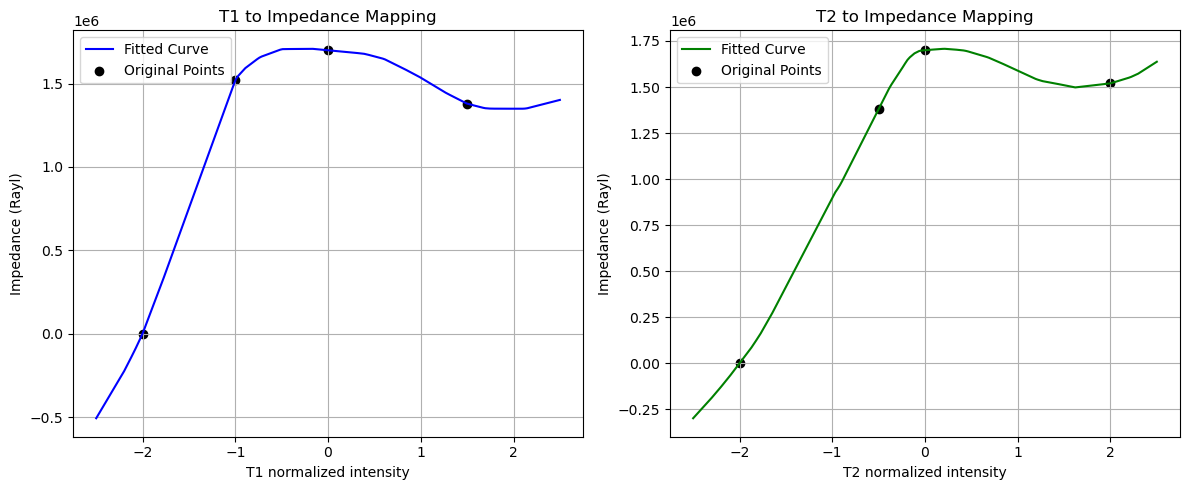

In [62]:
# Ground-truth values for T1
t1_values = np.array([-2.0, -1.0, 0.0, 1.5]).reshape(-1, 1)
impedances_t1 = np.array([400, 1.52e6, 1.7e6, 1.38e6]).reshape(-1, 1) / 1e6

# Ground-truth values for T2
t2_values = np.array([-2.0, -0.5, 0.0, 2.0]).reshape(-1, 1)
impedances_t2 = np.array([400, 1.38e6, 1.7e6, 1.52e6]).reshape(-1, 1) / 1e6

# Convert to torch tensors
X_t1 = torch.tensor(t1_values, dtype=torch.float32)
y_t1 = torch.tensor(impedances_t1, dtype=torch.float32)
X_t2 = torch.tensor(t2_values, dtype=torch.float32)
y_t2 = torch.tensor(impedances_t2, dtype=torch.float32)

# Train models
model_t1 = train_mlp(X_t1, y_t1)
model_t2 = train_mlp(X_t2, y_t2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot T1 model
x_plot = torch.linspace(-2.5, 2.5, 200).reshape(-1, 1)
with torch.no_grad():
    y_plot_t1 = model_t1(x_plot).cpu().numpy()
    y_plot_t1 = y_plot_t1 * 1e6
axs[0].plot(x_plot.numpy(), y_plot_t1, label='Fitted Curve', color='blue')
axs[0].scatter(t1_values, impedances_t1 * 1e6, color='black', label='Original Points')
axs[0].set_title('T1 to Impedance Mapping')
axs[0].set_xlabel('T1 normalized intensity')
axs[0].set_ylabel('Impedance (Rayl)')
axs[0].legend()
axs[0].grid()

# Plot T2 model
with torch.no_grad():
    y_plot_t2 = model_t2(x_plot).cpu().numpy()
    y_plot_t2 = y_plot_t2 * 1e6
axs[1].plot(x_plot.numpy(), y_plot_t2, label='Fitted Curve', color='green')
axs[1].scatter(t2_values, impedances_t2 * 1e6, color='black', label='Original Points')
axs[1].set_title('T2 to Impedance Mapping')
axs[1].set_xlabel('T2 normalized intensity')
axs[1].set_ylabel('Impedance (Rayl)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

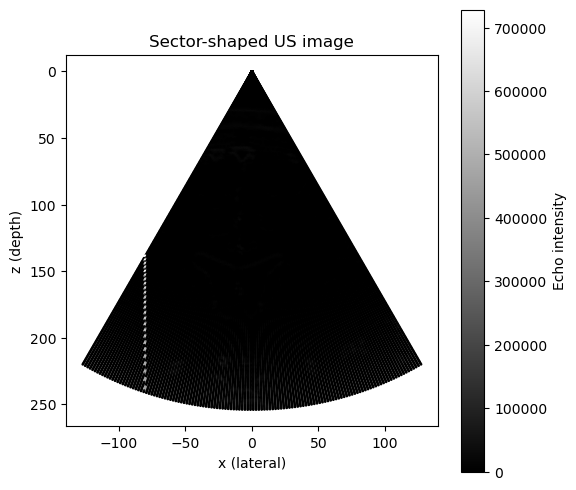

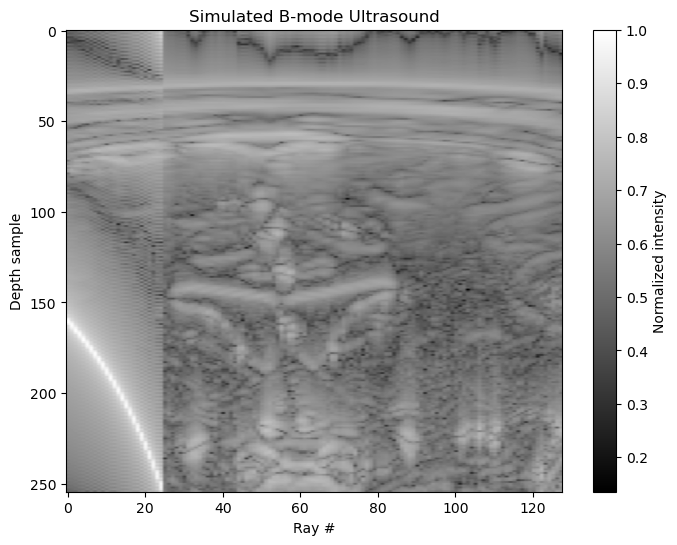

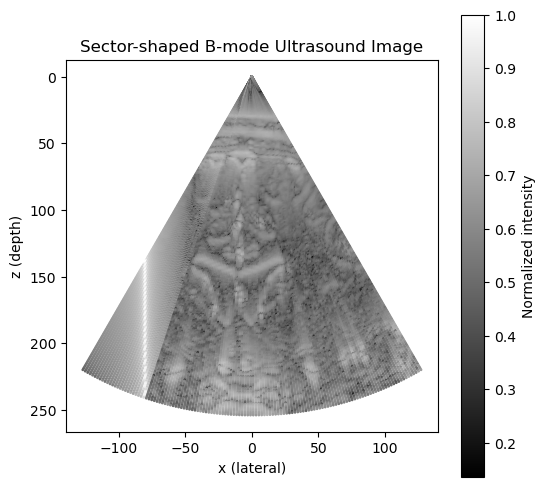

In [ ]:


# set up a fan of rays in the x-z plane (for a 2D slice)
N_rays = 128
theta_max = 30 * torch.pi / 180             # 30 degrees
angles = torch.linspace(-theta_max, theta_max, N_rays)
# rays lie in (x,z) plane: [cos, 0, sin]
directions = torch.stack([torch.sin(angles),
                          torch.zeros_like(angles),
                          torch.cos(angles)], dim=1)

# choose a source point
D, H, W = volume.shape
source = torch.tensor([80, 40, 0], dtype=torch.float32)

# simulate & plot
renderer = UltrasoundRenderer(num_samples=256, attenuation_coeff=0.8)
frame = renderer.simulate_frame(volume, source, directions)
# renderer.plot_frame(frame)
bmode = renderer.frame_to_bmode(frame)
renderer.plot_sector(frame, angles, spacing=1.0)
renderer.plot_bmode(bmode)
renderer.plot_sector_bmode(bmode, angles, spacing=1.0)

